Prior to this, the raw data has been parsed through the data_clean notebook. In that notebook, irregularities in the dataset have been removed which were consequences of the scraping, and 3 columns have been added, namely Province, which was derived from the Location, and using a dataset of all towns in the Netherlands, the province was found, Make, which was derived from the title and a dataset of all well-known car makes, and models, which was also derived from the title in a similar manner.

In this file, we will further explore the data, remove outliers, and try to learn as much about the data as possible.

Let's import the needed libraries and change the settings

In [1]:
import numpy as np
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

Reading in the main cleaned dataframe. The body column was very sparse, so we discarded it altogether.

In [2]:
df = pd.read_csv('data/cleaned/data_NoNaN.csv')
df

,Make,Model,Price,Year,Ran,Location,Province,Seller,Title
0,fiat,doblo,18500,2005.0,199313.0,Gennep,Limburg,I Boumans,fiat doblo cargo 1.9 jtd grijs kenteken bestel...
1,ford,ranger,22600,2017.0,107195.0,Barneveld,Gelderland,DUTCH Vans,ford ranger open-laadbak 2.2tdci 160pk dubbele...
2,aixam,roadline,6950,2008.0,47108.0,Beek,Limburg,Garage Kaal & Buunk,aixam roadline -2008- incl. 3 mnd garantie + o...
3,audi,a3,11000,2013.0,201500.0,Lent,Gelderland,Jeroen,audi a3 s-line sportback facelift 2013 wit
4,mercedes,sprinter,32900,2018.0,148939.0,Langerak,Drenthe,Van der Wal Vans,mercedes-benz sprinter 314cdi 143pk l2h2 koelw...
...,...,...,...,...,...,...,...,...,...
10682,volkswagen,h1,21800,2018.0,148087.0,Heel Nederland,In every province,Action Lease,volkswagen transporter l1 h1 2018 €306 per maand
10683,renault,h1,24700,2021.0,67051.0,Heel Nederland,In every province,Action Lease,renault trafic l2 h1 2021 €344 per maand
10684,renault,h1,41800,2022.0,60.0,Heel Nederland,In every province,Action Lease,renault master l3 h1 2022 €635 per maand
10685,volkswagen,h2,17600,2017.0,198504.0,Heel Nederland,In every province,Action Lease,volkswagen crafter l2 h2 2017 €247 per maand


Let's take a deeper look at the price column.

In [3]:
pd.options.display.float_format = '{:.2f}'.format
df["Price"].describe()

count     10687.00
mean      17838.60
std       79925.85
min           0.00
25%        3745.00
50%       12500.00
75%       21900.00
max     5749999.00
Name: Price, dtype: float64

As we can see below cars with a listing price more than 150k only make up 0.4% of all listings, there are also major outliers, like cars worth millions. For the sake of this project, we will discard these very high value cars.

In [4]:
count = 0
for price in df["Price"]:
    if price > 150000:
        count += 1
total = len(df["Price"])
percentage = count / total *100
number = len(df["Price"]) * (percentage /100)
percentage, number

(0.25264339852156825, 27.0)

Let's remove all cars below 500 and above 150000 euros.

In [5]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a winsorized data frame with outliers removed
    """
    return data.loc[(data[variable] > lower) & (data[variable] < upper)]


df = remove_outliers(df, 'Price', lower=500, upper=150001)
df = df.drop_duplicates()

In [6]:
df["Price"].describe()


count     5884.00
mean     18304.25
std      16617.02
min        505.00
25%       6950.00
50%      14600.00
75%      23900.00
max     149999.00
Name: Price, dtype: float64

Let's continue by looking at the price distribuion of all car listings.

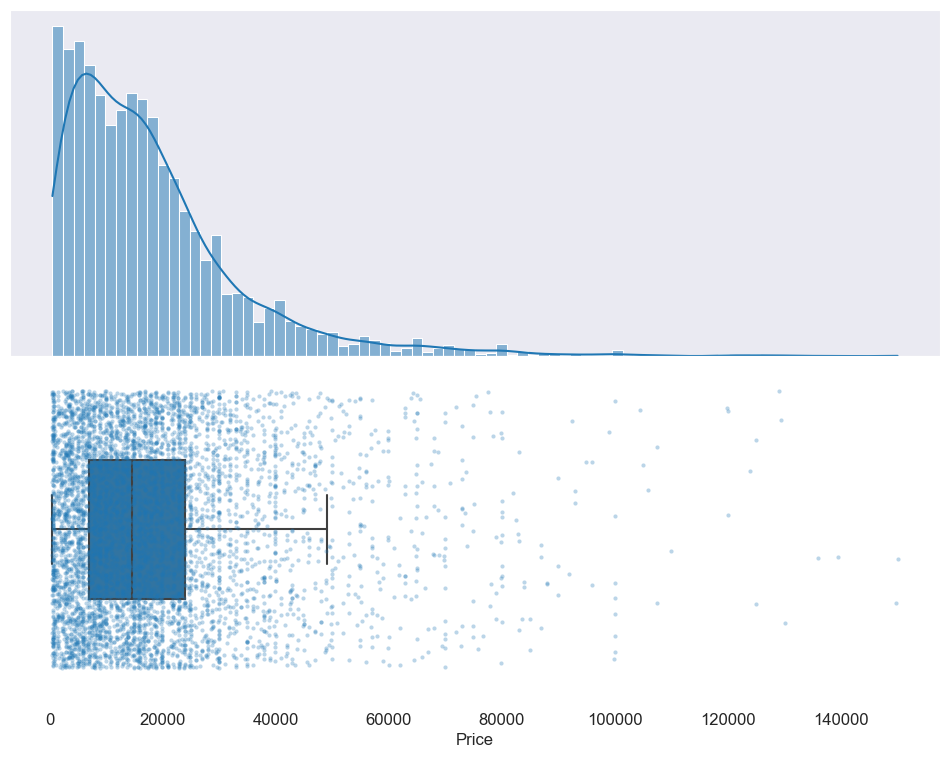

In [7]:
df = df.reset_index(drop=True)
fig, axs = plt.subplots(nrows=2)

sns.histplot(
    df["Price"],
    kde=True,
    ax=axs[0]
)

sns.stripplot(
    df["Price"], 
    orient='h',
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    df["Price"],
    orient='h',
    width=0.4, 
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(df["Price"]) * 0.05
xmin = np.min(df["Price"]) - spacer
xmax = np.max(df["Price"]) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white
axs[1].set_facecolor('white')

A potential outlier is the lowest price bin. In the collection of the data, we attempted to collect private and company listings seperately, marktplaats, however, did not do a very good job at that. We loaded the dataframe as a whole, meaning that we have both private and company listings in the dataframe. The low price  listings are very likely lease options, in which we are not interested.
Let's take a look.

In [8]:
df.loc[df.Price<1000]

,Make,Model,Price,Year,Ran,Location,Province,Seller,Title
31,peugeot,206,695,2005.00,232500.00,Hilversum,Noord-Holland,hydra,peugeot 206 quicksilver 1.4xs 16v bjr2005
195,porsche,cayenne,626,2012.00,162865.00,Veenendaal,Utrecht,ROS finance,porsche cayenne 4.8 gts | sport chrono | leder...
196,audi,q5,879,2020.00,32765.00,Veenendaal,Utrecht,ROS finance,audi q5 55 tfsi e 367pk 20inch 3x s-line lucht...
207,mercedes,200,621,2018.00,39945.00,Veenendaal,Utrecht,ROS finance,mercedes-benz a-klasse 200 *amg edition 1* pan...
364,peugeot,206,900,2001.00,149000.00,Rotterdam,Zuid-Holland,Hofman,peugeot 206 1.4 x-line 3d 2001 blauw
...,...,...,...,...,...,...,...,...,...
5758,volkswagen,fox,850,2006.00,220516.00,Amersfoort,Utrecht,Autohandel Honing,volkswagen fox 1.2 trendline
5774,mercedes,200,995,1997.00,353664.00,Amersfoort,Utrecht,Autohandel Honing,mercedes-benz clk-klasse coupé 200 sport
5844,mercedes,sprinter,763,2021.00,76857.00,Heel Nederland,In every province,Regeljelease.nl,mercedes-benz sprinter | 319
5854,mercedes,sprinter,796,2021.00,88534.00,Heel Nederland,In every province,Regeljelease.nl,mercedes-benz sprinter | 319 3.0 cdi v6 aut. l2h2


Looking at the table above shows that many of these cars are leases. This can be seen by the fact that the seller name and title contain the word lease, and also by the fact that cars under 1000 should mostly be low value old cars, not a 2012 4.8 Porsche Cayenne :).

We can try to remove lease options by first of all looking at which titles and sellers contain the words lease, finance, etc.
We could also make an argument for a correlation between Year and price, and decide that cars built after a certain year should not be less than 1000 euros.
Let's remove all listings in which the Title or the Seller contain the words lease or finance

In [9]:
df = df[~df.Title.str.contains('lease|finance', case=False)]
df = df[~df.Seller.str.contains('lease|finance', case=False)]
df

,Make,Model,Price,Year,Ran,Location,Province,Seller,Title
0,fiat,doblo,18500,2005.00,199313.00,Gennep,Limburg,I Boumans,fiat doblo cargo 1.9 jtd grijs kenteken bestel...
1,ford,ranger,22600,2017.00,107195.00,Barneveld,Gelderland,DUTCH Vans,ford ranger open-laadbak 2.2tdci 160pk dubbele...
2,aixam,roadline,6950,2008.00,47108.00,Beek,Limburg,Garage Kaal & Buunk,aixam roadline -2008- incl. 3 mnd garantie + o...
3,audi,a3,11000,2013.00,201500.00,Lent,Gelderland,Jeroen,audi a3 s-line sportback facelift 2013 wit
4,mercedes,sprinter,32900,2018.00,148939.00,Langerak,Drenthe,Van der Wal Vans,mercedes-benz sprinter 314cdi 143pk l2h2 koelw...
...,...,...,...,...,...,...,...,...,...
5859,volkswagen,transporter,28700,2017.00,145751.00,Barneveld,Gelderland,DUTCH Vans,volkswagen transporter personenbus 2.0tsi komb...
5867,volkswagen,h1,14600,2012.00,183398.00,Barneveld,Gelderland,Dutchvans.com,volkswagen crafter h1 l5 diesel 2012 groen
5868,ford,transit,16700,2016.00,95864.00,Barneveld,Gelderland,DUTCH Vans,ford transit kipper 2.0tdci 3-zijdige kipper |...
5869,mercedes,h1,19300,2018.00,226713.00,Barneveld,Gelderland,Dutchvans.com,mercedes-benz sprinter h1 l4 diesel 2018 wit


That removed quite some rows! Let's look at the price distribution again.

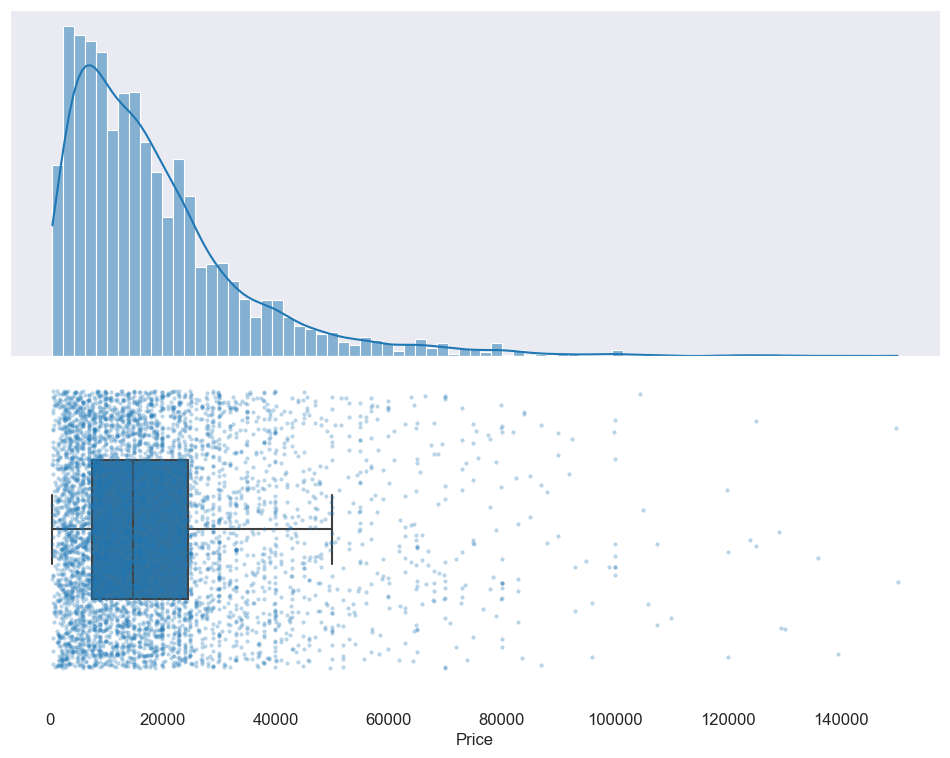

In [10]:
df = df.reset_index(drop=True)
fig, axs = plt.subplots(nrows=2)

sns.histplot(
    df["Price"],
    kde=True,
    ax=axs[0]
)

sns.stripplot(
    df["Price"],
    orient='h',
    jitter=0.4,
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    df["Price"],
    orient='h',
    width=0.4,
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(df["Price"]) * 0.05
xmin = np.min(df["Price"]) - spacer
xmax = np.max(df["Price"]) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white
axs[1].set_facecolor('white')

This distribution makes much more sense. Now let's look at the distribution and listing prices of cars per province and how many cars are sold in each province.

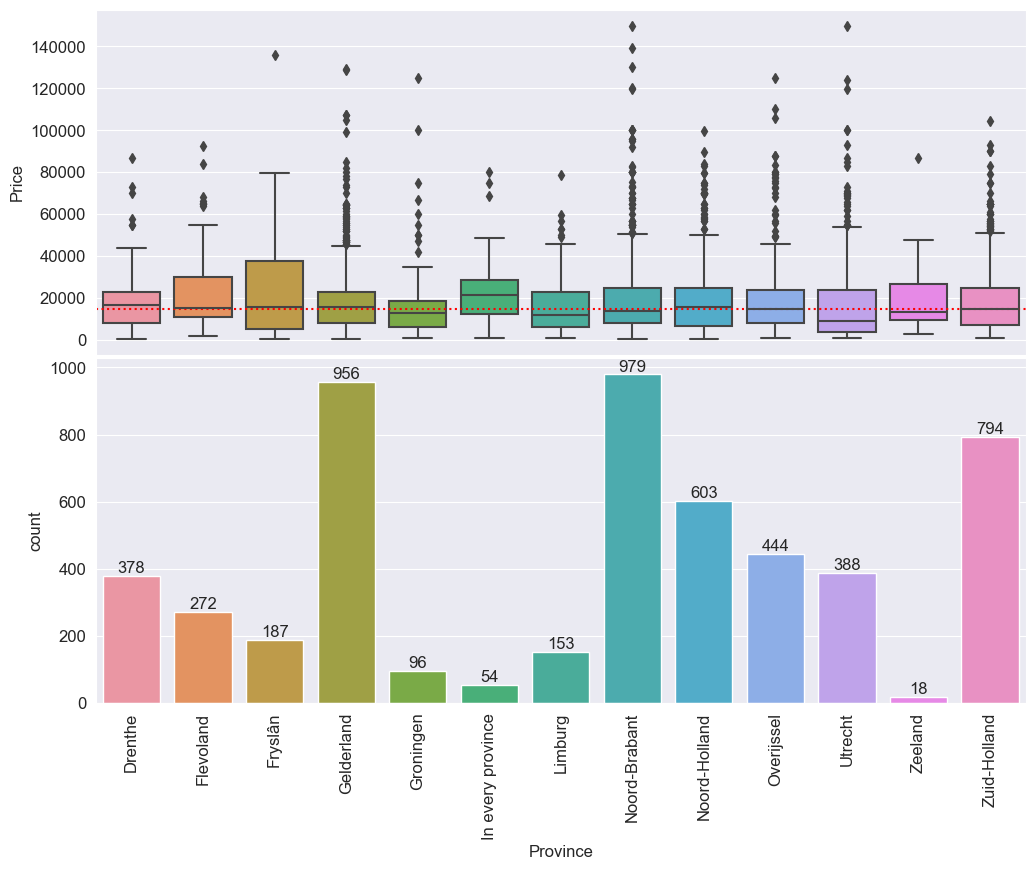

In [11]:
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x='Province',
    y='Price',
    data=df.sort_values('Province'),
    ax=axs[0]
)

sns.countplot(
    x='Province',
    data=df.sort_values('Province'),
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y=df['Price'].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.01)

Now we can see that the mean listing price the cars are pretty close to each other for all of the provinces, but we do however see large difference in the amount of listings per province. But this is probably because most of these provinces are in the Randstad where much more people live as opposed to provinces such as Limburg, Zeeland, and Drenthe for example.
Now let's also look at the correlation between the Year the car was built and the Price.

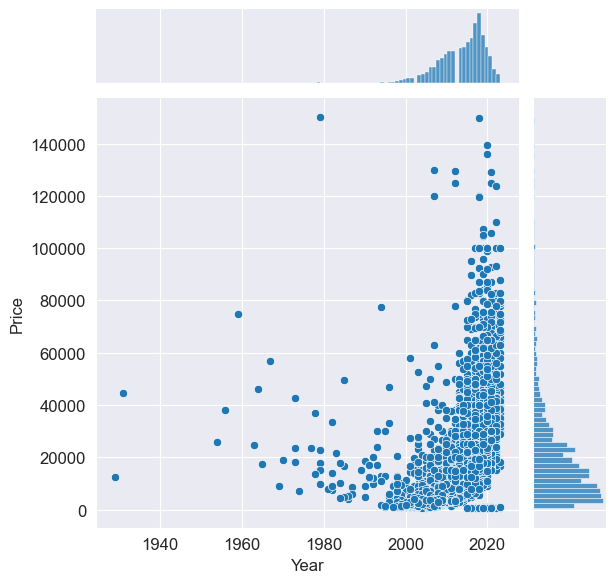

In [12]:
sns.jointplot(x='Year', y='Price', data=df)

We are removing cars before the year of 1995, as they cause much noise but are relatively sparse. They are noisy because some old cars have high value because of their old age, while othersare simply old and unreliable and therefore have the opposite effect. This is difficult to predict, and adds more noise that it does good.

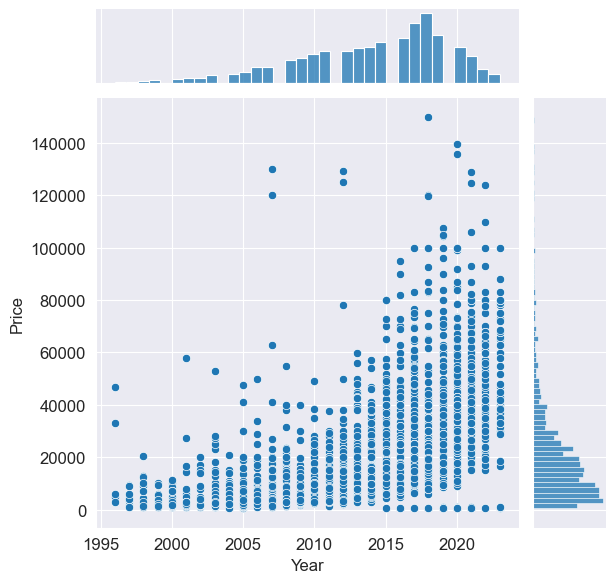

In [13]:
df = df[df.Year>1995]
sns.jointplot(x='Year', y='Price', data=df)

In this plot we can see that, from from 2005 to 2015, no cars are in the lowest price bracket. However, from 2015 to current, that bracket is populated again. Let's try removing all cars that are built from 2014 onwards, but are listed at a price lower than 1000 euros. These are very likely lease options.

In [14]:
df[(df.Year>=2013) & (df.Price<=1000)]

,Make,Model,Price,Year,Ran,Location,Province,Seller,Title
703,mercedes,sprinter,616,2021.00,48687.00,Langerak,Drenthe,Van der Wal Vans,mercedes-benz sprinter 317cdi 170pk l3h2 euro6...
783,dodge,ram,899,2023.00,10.00,Nuland,Noord-Brabant,Millbrooks,"dodge ram 1500 5.7 v8 limited night, op voorra..."
1038,renault,m3,520,2023.00,150.00,Arnhem,Gelderland,Vissinga Automotive B.V.,renault master 10x bakwagen met 1000 kg laadkl...
1110,volkswagen,crafter,709,2022.00,34.00,Vaassen,Gelderland,Dethi Vans,volkswagen crafter 2.0tdi 140pk automaat l3h2 ...
1311,volkswagen,transporter,800,2020.00,64118.00,Leeuwarden,Fryslân,Bedrijfswagen centrum Leeuwarden,volkswagen transporter 2.0tdi 199pk 7-dsg dc b...
1313,mercedes,sprinter,687,2020.00,27157.00,Leeuwarden,Fryslân,Bedrijfswagen centrum Leeuwarden,mercedes-benz sprinter 319 3.0cdi v6 190pk aut...
1504,ford,transit,516,2021.00,38669.00,Vaassen,Gelderland,Dethi Vans,ford transit custom 2.0tdci lang raptor editio...
1576,mercedes,sprinter,551,2020.00,92866.00,Langerak,Drenthe,Van der Wal Vans,mercedes-benz sprinter 316cdi 163pk l3h2 euro6...
1964,mercedes,sprinter,535,2019.00,135193.00,Langerak,Drenthe,Van der Wal Vans,mercedes-benz sprinter 316cdi 163pk bakwagen +...
2397,dodge,ram,799,2023.00,1.00,Nuland,Noord-Brabant,Millbrooks,dodge ram 1500 nieuw 2023 met lpg 6 jaar fabri...


<Axes: xlabel='Year', ylabel='Price'>

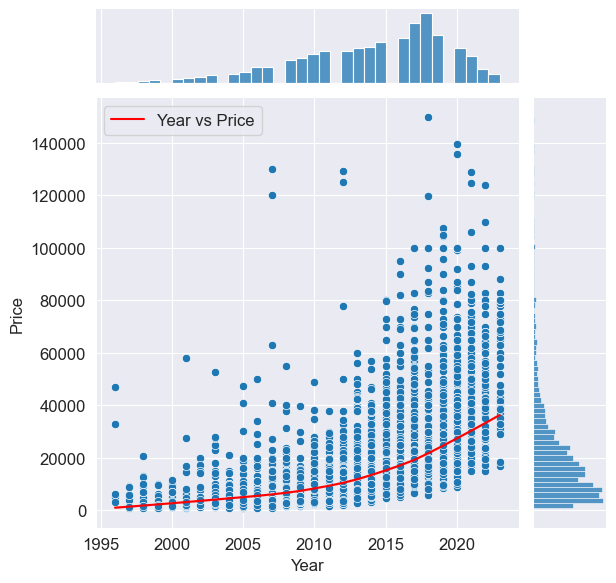

In [15]:
df = df[(df.Year<=2013) | (df.Price>=1000)]
sns.jointplot(x='Year', y='Price', data=df)
xobs = df.Year
yobs = df.Price
ysmooth = lowess(yobs, xobs, return_sorted=False)
sns.lineplot(x=xobs, y=ysmooth, label='Year vs Price', color='red')

Let's take a look at the correlation between the mileage of the car versus the price. We see a clear trend, where cars with less mileage are more expensive.

<Axes: xlabel='Price', ylabel='Ran'>

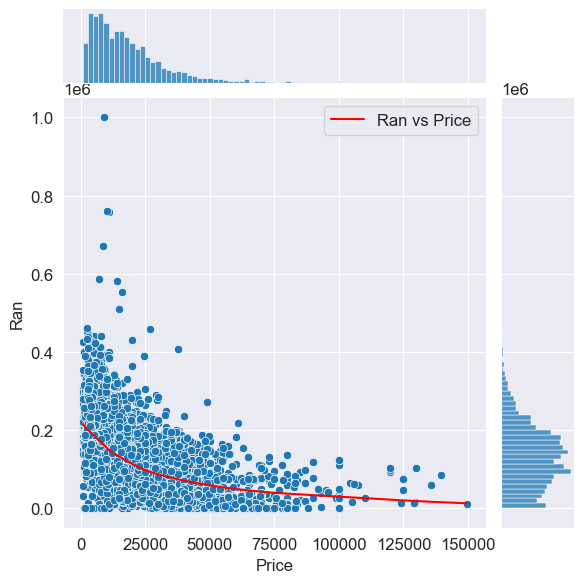

In [16]:
sns.jointplot(x='Price', y='Ran', data=df)
xobs = df.Price
yobs = df.Ran
ysmooth = lowess(yobs, xobs, return_sorted=False)
sns.lineplot(x=xobs, y=ysmooth, label='Ran vs Price', color='red')

Regressing based on year and mileage is interesting, however, a 2018 audi with 100.000 km is not the same price as a 2018 hyundai.
In the preprocessing, we have added makes and models of each vehicle. Let's see what information we can get from this!

In [17]:
df

,Make,Model,Price,Year,Ran,Location,Province,Seller,Title
0,fiat,doblo,18500,2005.00,199313.00,Gennep,Limburg,I Boumans,fiat doblo cargo 1.9 jtd grijs kenteken bestel...
1,ford,ranger,22600,2017.00,107195.00,Barneveld,Gelderland,DUTCH Vans,ford ranger open-laadbak 2.2tdci 160pk dubbele...
2,aixam,roadline,6950,2008.00,47108.00,Beek,Limburg,Garage Kaal & Buunk,aixam roadline -2008- incl. 3 mnd garantie + o...
3,audi,a3,11000,2013.00,201500.00,Lent,Gelderland,Jeroen,audi a3 s-line sportback facelift 2013 wit
4,mercedes,sprinter,32900,2018.00,148939.00,Langerak,Drenthe,Van der Wal Vans,mercedes-benz sprinter 314cdi 143pk l2h2 koelw...
...,...,...,...,...,...,...,...,...,...
5317,volkswagen,transporter,28700,2017.00,145751.00,Barneveld,Gelderland,DUTCH Vans,volkswagen transporter personenbus 2.0tsi komb...
5318,volkswagen,h1,14600,2012.00,183398.00,Barneveld,Gelderland,Dutchvans.com,volkswagen crafter h1 l5 diesel 2012 groen
5319,ford,transit,16700,2016.00,95864.00,Barneveld,Gelderland,DUTCH Vans,ford transit kipper 2.0tdci 3-zijdige kipper |...
5320,mercedes,h1,19300,2018.00,226713.00,Barneveld,Gelderland,Dutchvans.com,mercedes-benz sprinter h1 l4 diesel 2018 wit


In [18]:
df_makes = df[['Make', 'Price', 'Ran', 'Year']].groupby(by='Make').agg({'Price':'mean', 'Year':'mean','Ran':'mean'})

In [19]:
df_makes['Make'] = df_makes.index
df_makes

,Price,Year,Ran,Make
Make,,,,
aixam,11261.23,2015.00,21418.08,aixam
alfa romeo,21704.67,2012.06,138241.67,alfa romeo
audi,27838.49,2014.42,136034.71,audi
bentley,46968.00,2003.20,106578.20,bentley
bmw,26233.93,2013.10,161522.59,bmw
cadillac,44950.00,2015.00,92100.00,cadillac
chevrolet,16708.50,2009.25,135620.62,chevrolet
chrysler,4286.25,2005.00,236297.25,chrysler
citroen,6832.37,2011.94,139375.85,citroen


<Axes: xlabel='Make', ylabel='Price'>

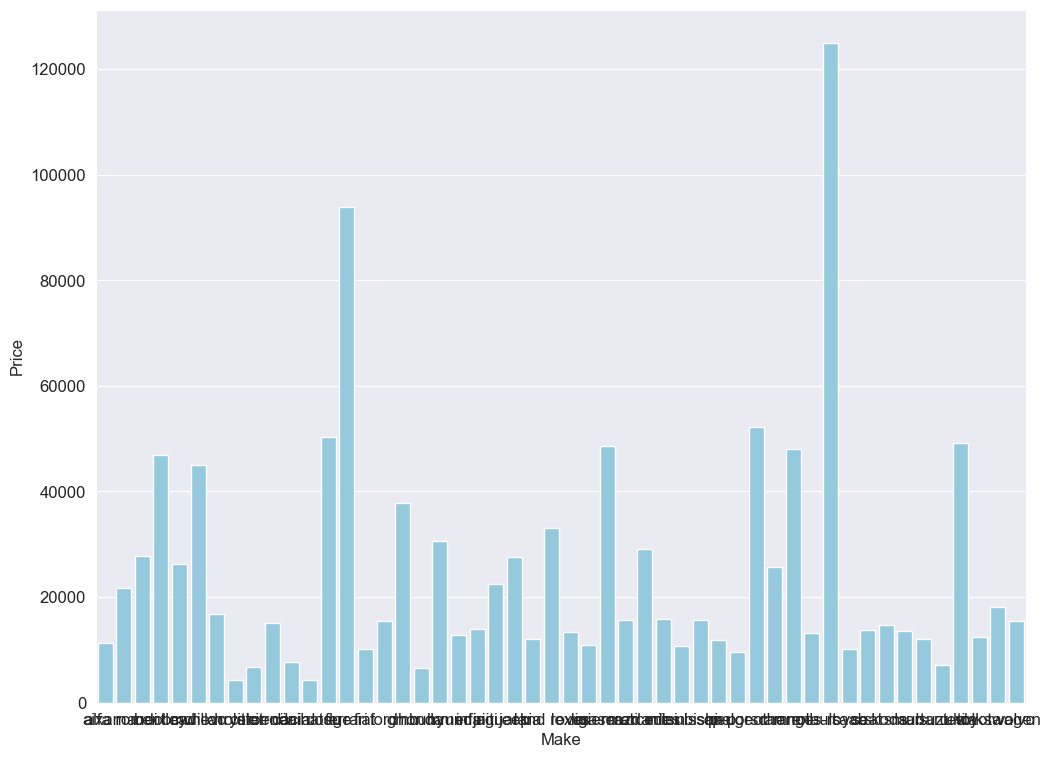

In [20]:
sns.barplot(x='Make', y='Price', data=df_makes, color='skyblue')

While this visualization is not very interpretable, it does tell us that there is a lot of variation in the means of the prices of specific makes. It was likely a good choice to sacrifice some data to add the makes as a feature.

In [21]:
model_counts = df['Model'].value_counts()
valid_models = model_counts[model_counts >= 5].index.tolist()
df = df[df['Model'].isin(valid_models)]

In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Define X and y
X = df[['Make', 'Model', 'Year', 'Ran']]
y = df['Price']

# OHE's
X = pd.get_dummies(X)

# Initialize K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=40)

# Initialize a list to store the RMSE for each fold
rmse_list = []
r2_list = []
# Loop through each fold
for train_idx, test_idx in kf.split(X, y):
    # Split
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    # Fit
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Calculate metrics
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    rmse_list.append(rmse)
    r2_list.append(r2)
# Calculate avg
avg_rmse = np.mean(rmse_list)
avg_r2 = np.mean(r2_list)

print(f"RMSE: {avg_rmse:.2f}")
print(f"R^2: {avg_r2:.2f}")

RMSE: 7896.76
R^2: 0.75


The metrics look good! Let's plot the residuals to inspect the model visually.

Text(0, 0.5, 'Residuals (Actual Price - Predicted Price)')

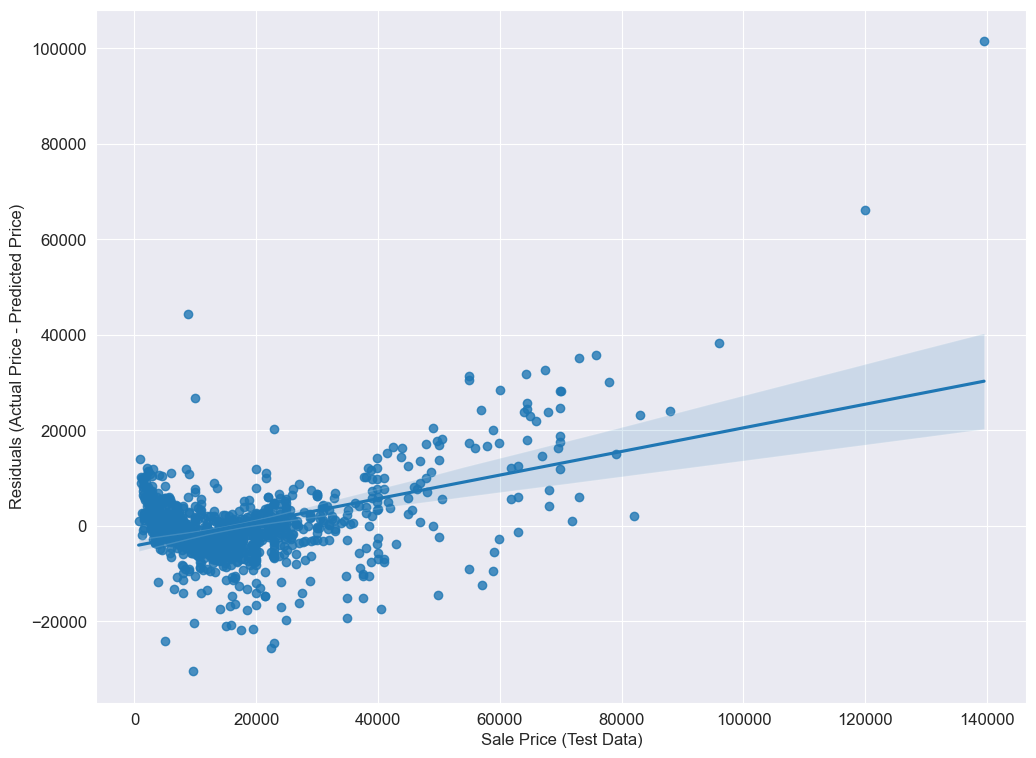

In [29]:
gm1_residuals = y_test - y_pred
ax = sns.regplot(x=y_test, y=gm1_residuals)
ax.set_xlabel('Sale Price (Test Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')

The data looks quite homogenous around 0, we do underfit a little at higher prices but as this is quite sparse data that is expected.